In [1]:
import sys

sys.path.append("../")
from library.datasets import LungCancerDataset
from library.train import create_dataloader
from entrypoint import lung_scoring_function
import matplotlib.pyplot as plt
import torch
from library.models import *
import random
import glob
from icecream import ic
import copy
import pprint
import pandas as pd
from tqdm.auto import tqdm

In [2]:
best_lung_models_combined = [
    i for i in glob.glob("../lung_training/**/*Model.pt", recursive=True)
]

In [3]:
lung_dir = "../datasets/train_lung/"
random_seed = 42024
number_of_buckets = 400
months_per_gt_bucket = 0.5

val_dataset = LungCancerDataset(
    lung_dir,
    split_type="val",
    random_seed=random_seed,
    number_of_buckets=number_of_buckets,
    months_per_gt_bucket=months_per_gt_bucket,
)
test_dataset = LungCancerDataset(
    lung_dir,
    split_type="test",
    random_seed=random_seed,
    number_of_buckets=number_of_buckets,
    months_per_gt_bucket=months_per_gt_bucket,
)

Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

In [4]:
val_loader = create_dataloader(val_dataset, batch_size=6, shuffle=False)
test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)

In [5]:
path_to_model = {
    "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
    "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
        number_of_buckets=number_of_buckets
    ),
}
test_path = "../lung_training/metadata_augmentation/LungCombinedResnet18PretrainedModel/2023-12-12_21-54-04/400_buckets_0.5_months/['layer2', 'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt"
lung_model_base = path_to_model[test_path.split("_")[-1]]

In [6]:
# load model
model_state_dict = torch.load(test_path)
model = copy.deepcopy(lung_model_base)
model.load_state_dict(model_state_dict)
model = model.eval()

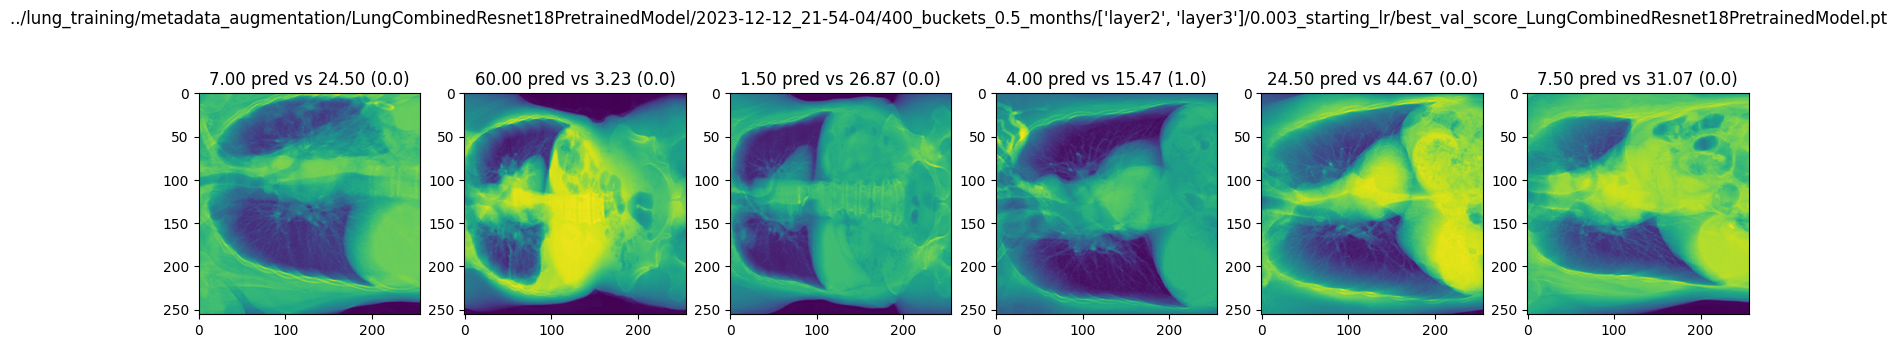

In [7]:
# Prostate models loop
epoch_targets = []
epoch_preds = []
epoch_outputs = []
for batch_idx, (images, metadata, targets) in enumerate(val_loader):
    data = images, metadata.squeeze()
    if isinstance(targets, list):
        pfs = targets[1]
        targets = targets[0]
    else:
        targets = targets
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)

    estimates = torch.nn.functional.softmax(output, dim=1)
    epoch_preds.extend([i.item() for i in pred])
    epoch_outputs.extend([i for i in estimates])
    epoch_targets.extend(pfs)
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for ind in range(images.shape[0]):
    ax[ind].imshow(images[ind][4])
    ax[ind].set_title(
        f"{pred[ind].item()*months_per_gt_bucket:0.2f} pred vs {pfs[ind][1]:0.2f} ({pfs[ind][0]})"
    )
fig.suptitle(test_path)
score = lung_scoring_function(months_per_gt_bucket, epoch_targets, epoch_preds)

In [8]:
pprint.pprint(test_path)
pprint.pprint(score)

("../lung_training/metadata_augmentation/LungCombinedResnet18PretrainedModel/2023-12-12_21-54-04/400_buckets_0.5_months/['layer2', "
 "'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt")
0.8037974683544303


In [9]:
def load_saved_model(model_path, path_to_model):
    model_base = path_to_model[model_path.split("_")[-1]]
    model_state_dict = torch.load(model_path)
    model = copy.deepcopy(model_base)
    model.load_state_dict(model_state_dict)
    model = model.eval()

    return model

In [10]:
def evaluate_lung_model(
    eval_dataloader,
    model_path,
    path_to_model,
    verbose=False,
    visualize=False,
    eval_id=None,
):
    model = load_saved_model(model_path, path_to_model)

    epoch_targets = []
    epoch_preds = []
    epoch_outputs = []
    for batch_idx, (images, metadata, targets) in enumerate(eval_dataloader):
        data = images, metadata.squeeze()
        if isinstance(targets, list):
            pfs = targets[1]
            targets = targets[0]
        else:
            targets = targets
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        estimates = torch.nn.functional.softmax(output, dim=1)
        epoch_preds.extend([i.item() for i in pred])
        epoch_outputs.extend([i for i in estimates])
        epoch_targets.extend(pfs)

    score = lung_scoring_function(months_per_gt_bucket, epoch_targets, epoch_preds)
    if eval_id is not None:
        score_dict = {f"{eval_id}_c_index": score}
    else:
        score_dict = {"c_index": score}

    model_details = model_path.split("/")[2:]

    if verbose:
        pprint.pprint(model_details)
        pprint.pprint(score_dict)
        print("\n\n")

    if visualize and score > 0.7:
        fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))
        for ind in range(images.shape[0]):
            ax[ind].imshow(images[ind][4])
            ax[ind].set_title(
                f"{pred[ind].item()*months_per_gt_bucket:0.2f} pred vs {pfs[ind][1]:0.2f} actual"
            )
        fig.suptitle(f"{model_path} - {score:0.4f}")
    return score_dict

In [11]:
val_results = {}
for model_path in tqdm(best_lung_models_combined):
    results = evaluate_lung_model(val_loader, model_path, path_to_model, eval_id="val")
    val_results[model_path] = results

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

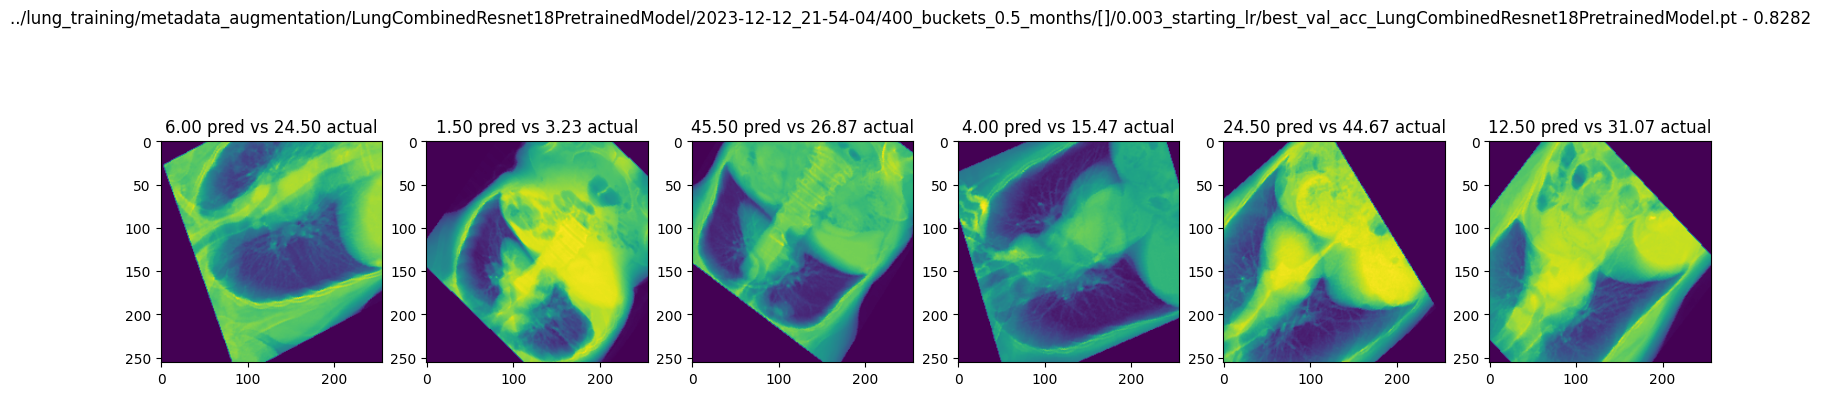

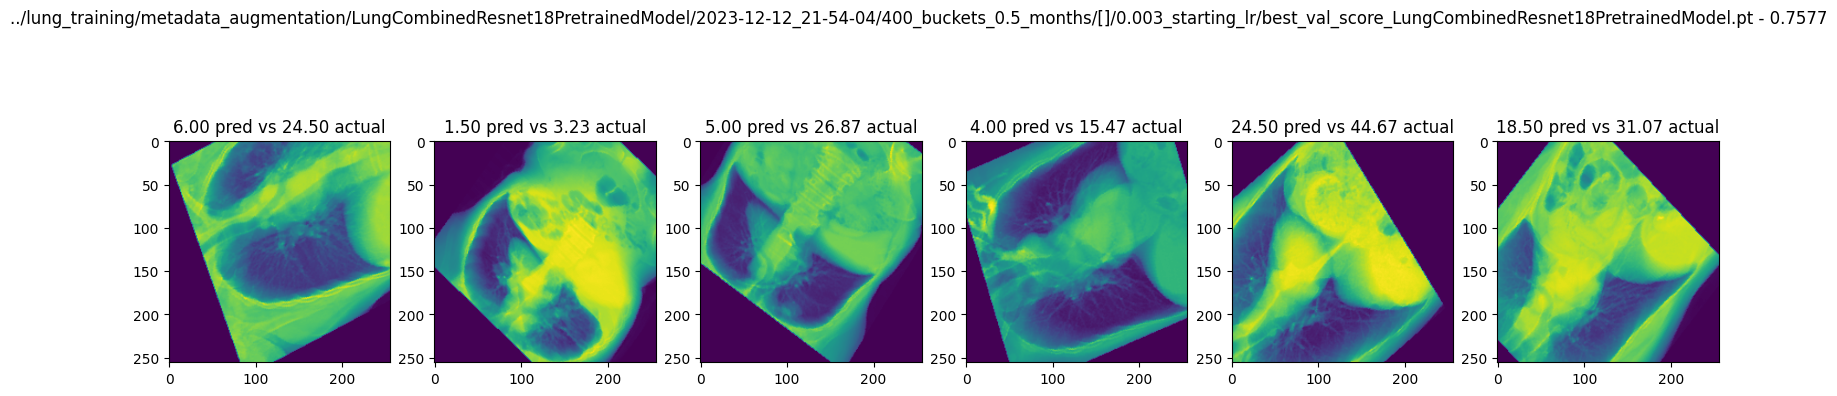

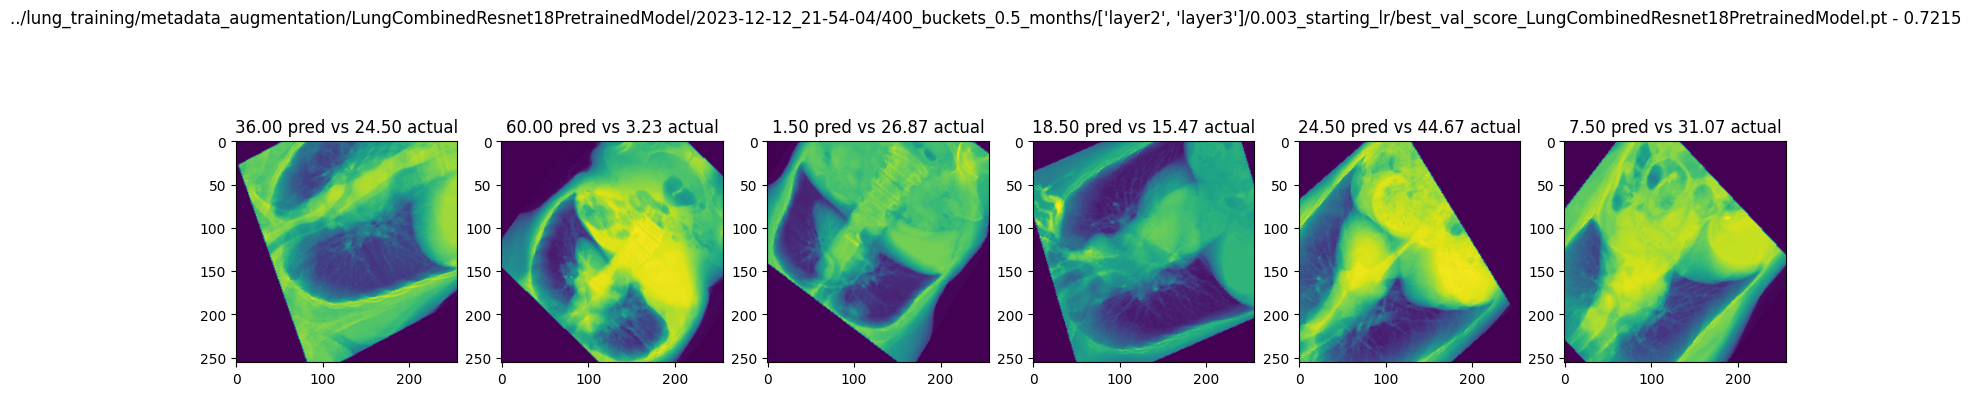

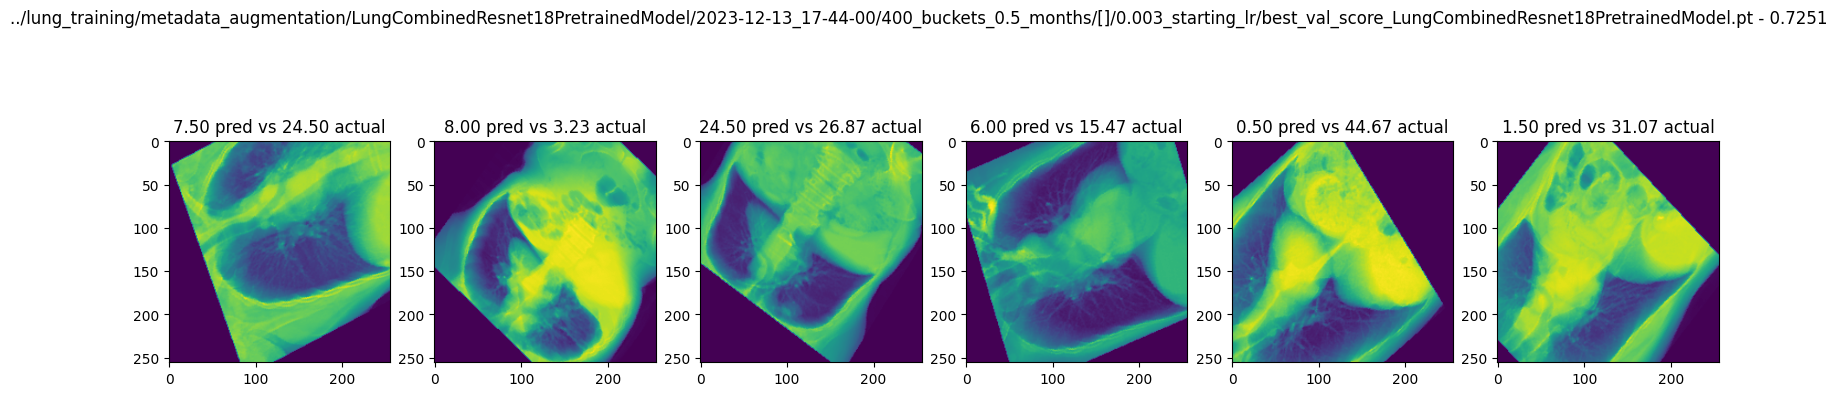

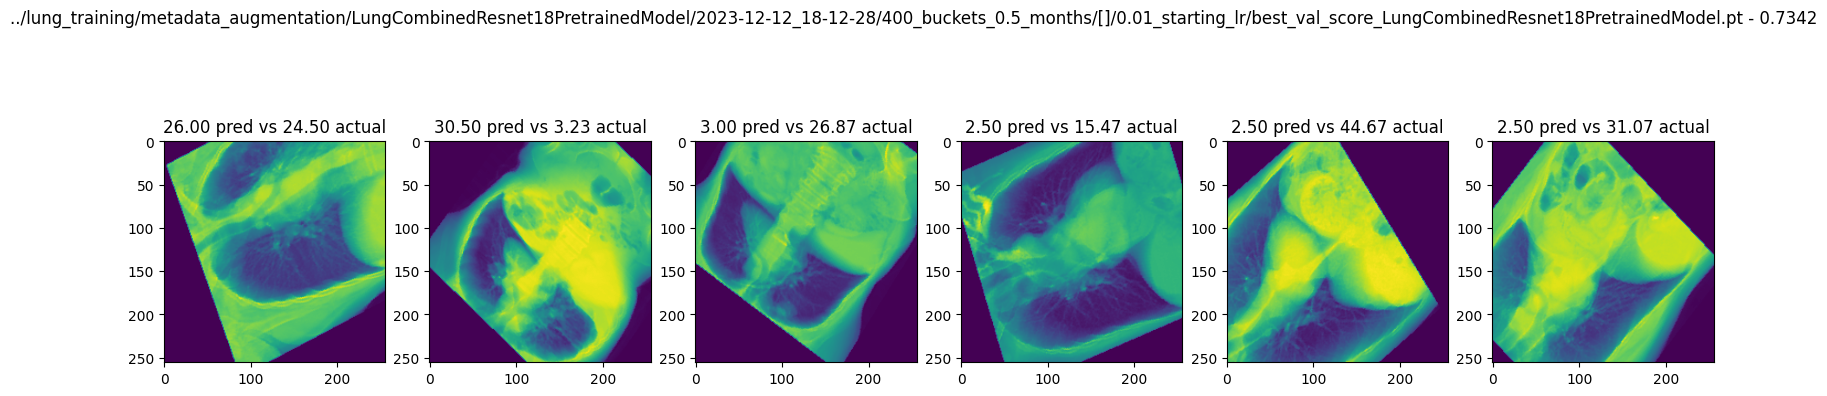

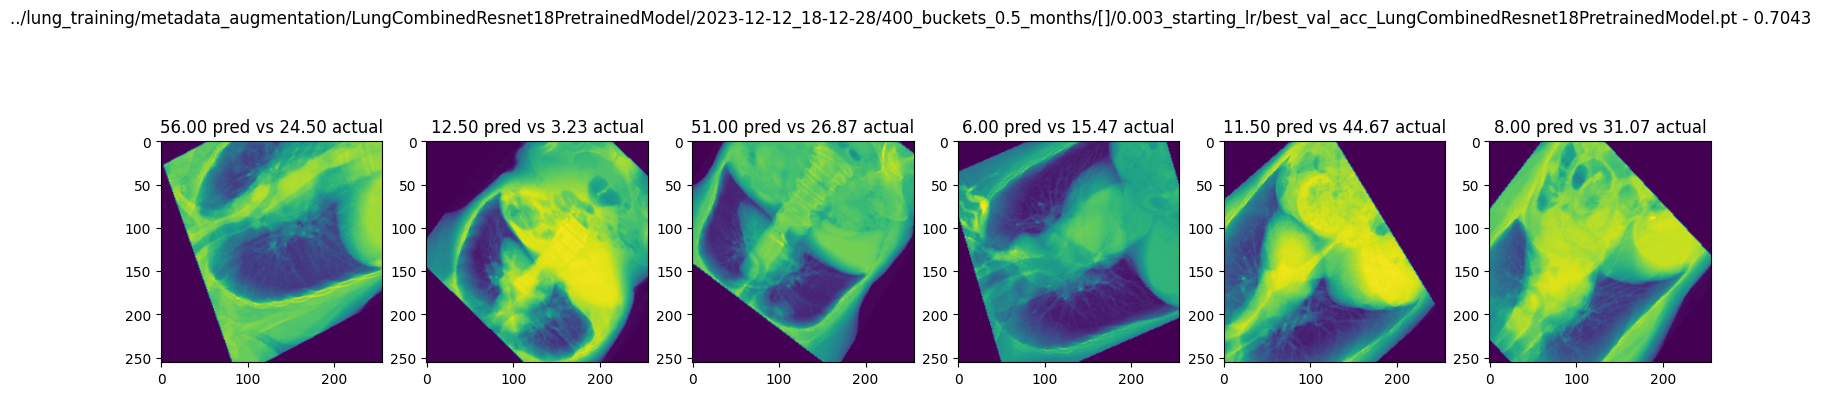

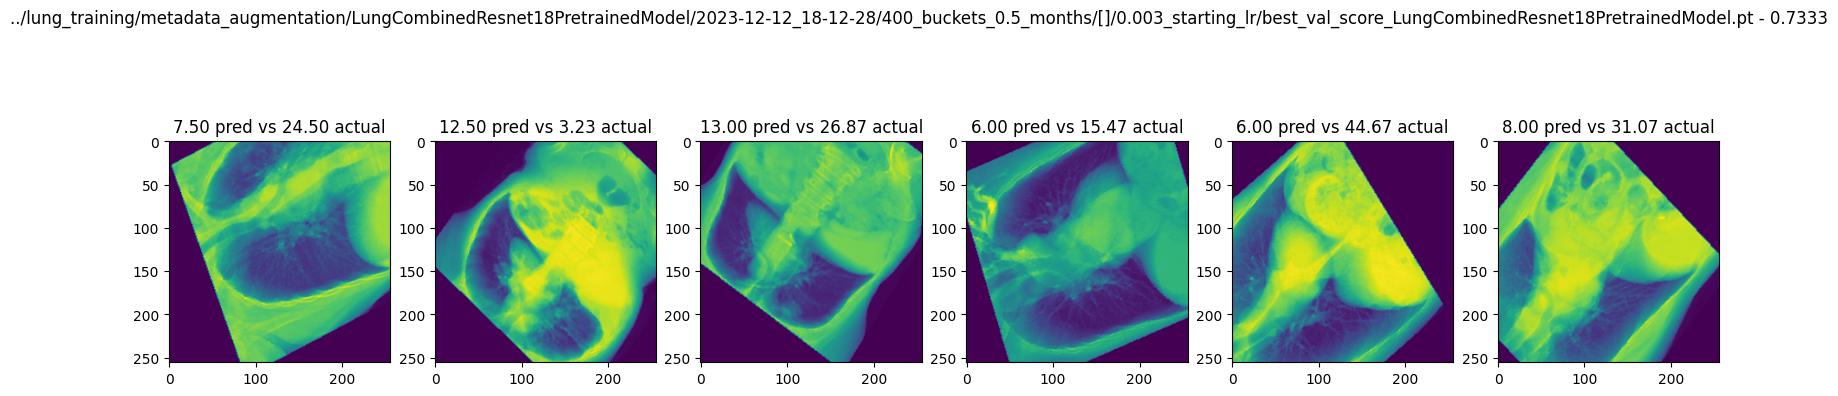

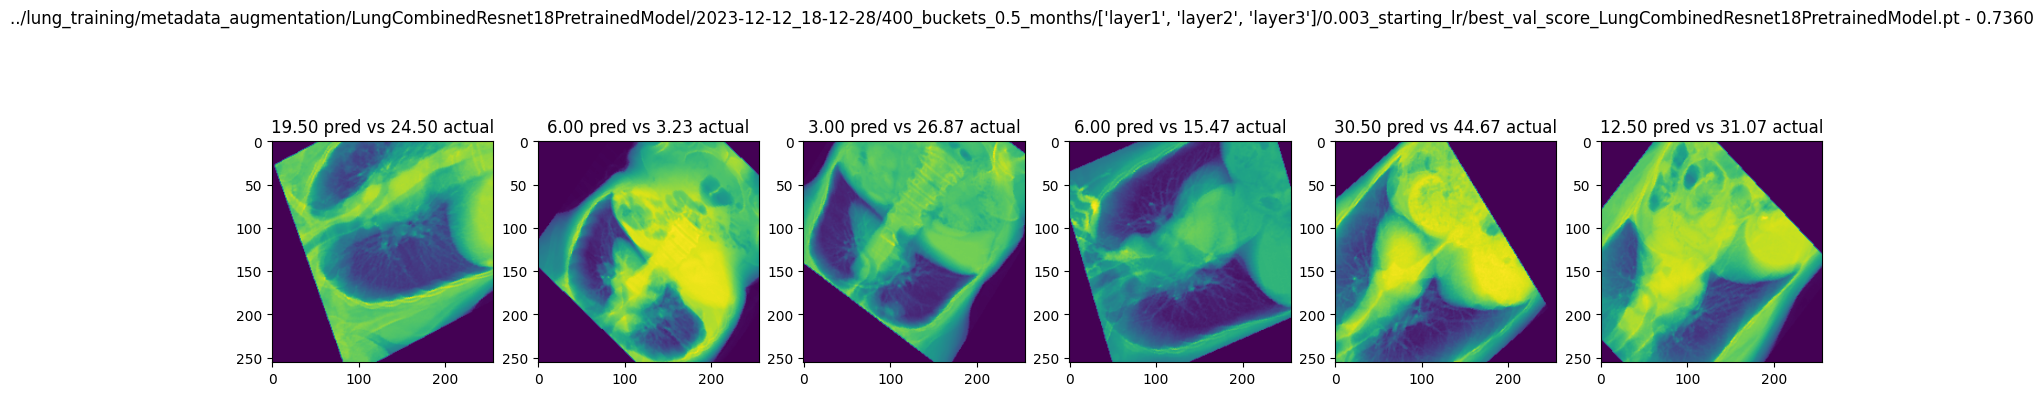

In [12]:
test_results = {}
for model_path in tqdm(best_lung_models_combined):
    results = evaluate_lung_model(
        test_loader, model_path, path_to_model, visualize=True, eval_id="test"
    )
    test_results[model_path] = results

In [13]:
val_df = pd.DataFrame.from_dict(val_results, orient="index")
test_df = pd.DataFrame.from_dict(test_results, orient="index")

In [14]:
val_df

val_c_index
../lung_training/LungCombinedModel/2023-12-11_2...     0.691682
../lung_training/LungCombinedModel/2023-12-11_2...     0.603978
../lung_training/LungCombinedModel/2023-12-11_2...     0.626582
../lung_training/LungCombinedModel/2023-12-11_2...     0.500000
../lung_training/LungCombinedModel/2023-12-11_2...     0.721519
../lung_training/metadata_augmentation/LungComb...     0.425859
../lung_training/metadata_augmentation/LungComb...     0.576854
../lung_training/metadata_augmentation/LungComb...     0.451175
../lung_training/metadata_augmentation/LungComb...     0.669982
../lung_training/metadata_augmentation/LungComb...     0.544304
../lung_training/metadata_augmentation/LungComb...     0.624774
../lung_training/metadata_augmentation/LungComb...     0.603978
../lung_training/metadata_augmentation/LungComb...     0.676311
../lung_training/metadata_augmentation/LungComb...     0.567812
../lung_training/metadata_augmentation/LungComb...     0.703436
../lung_training/metadata_augmentation/LungComb...     0.627486
../lung_training/metadata_augmentation/LungComb...     0.735081
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.791139
../lung_training/metadata_augmentation/LungComb...     0.594033
../lung_training/metadata_augmentation/LungComb...     0.660036
../lung_training/metadata_augmentation/LungComb...     0.599458
../lung_training/metadata_augmentation/LungComb...     0.685353
../lung_training/metadata_augmentation/LungComb...     0.641049
../lung_training/metadata_augmentation/LungComb...     0.752260
../lung_training/metadata_augmentation/LungComb...     0.579566
../lung_training/metadata_augmentation/LungComb...     0.754069
../lung_training/metadata_augmentation/LungComb...     0.556058
../lung_training/metadata_augmentation/LungComb...     0.753165
../lung_training/metadata_augmentation/LungComb...     0.503617
../lung_training/metadata_augmentation/LungComb...     0.698915
../lung_training/metadata_augmentation/LungComb...     0.583183
../lung_training/metadata_augmentation/LungComb...     0.774864
../lung_training/metadata_augmentation/LungComb...     0.586799
../lung_training/metadata_augmentation/LungComb...     0.777577
../lung_training/metadata_augmentation/LungComb...     0.538879
../lung_training/metadata_augmentation/LungComb...     0.803797
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.787523
../lung_training/metadata_augmentation/LungComb...     0.650995
../lung_training/metadata_augmentation/LungComb...     0.763110
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.700723
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.572333
../lung_training/metadata_augmentation/LungComb...     0.653707
../lung_training/metadata_augmentation/LungComb...     0.479204
../lung_training/metadata_augmentation/LungComb...     0.683544
../lung_training/metadata_augmentation/LungComb...     0.483725
../lung_training/metadata_augmentation/LungComb...     0.739602
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.737794
../lung_training/metadata_augmentation/LungComb...     0.465642
../lung_training/metadata_augmentation/LungComb...     0.724231
../lung_training/metadata_augmentation/LungComb...     0.659132
../lung_training/metadata_augmentation/LungComb...     0.713382
../lung_training/metadata_augmentation/LungComb...     0.484629
../lung_training/metadata_augmentation/LungComb...     0.730561
../lung_training/metadata_augmentation/LungComb...     0.500000
../lung_training/metadata_augmentation/LungComb...     0.632911

In [15]:
test_df

test_c_index
../lung_training/LungCombinedModel/2023-12-11_2...      0.528933
../lung_training/LungCombinedModel/2023-12-11_2...      0.647378
../lung_training/LungCombinedModel/2023-12-11_2...      0.528933
../lung_training/LungCombinedModel/2023-12-11_2...      0.527125
../lung_training/LungCombinedModel/2023-12-11_2...      0.438517
../lung_training/metadata_augmentation/LungComb...      0.573237
../lung_training/metadata_augmentation/LungComb...      0.625678
../lung_training/metadata_augmentation/LungComb...      0.464738
../lung_training/metadata_augmentation/LungComb...      0.552441
../lung_training/metadata_augmentation/LungComb...      0.594033
../lung_training/metadata_augmentation/LungComb...      0.428571
../lung_training/metadata_augmentation/LungComb...      0.632911
../lung_training/metadata_augmentation/LungComb...      0.652803
../lung_training/metadata_augmentation/LungComb...      0.617541
../lung_training/metadata_augmentation/LungComb...      0.585895
../lung_training/metadata_augmentation/LungComb...      0.671790
../lung_training/metadata_augmentation/LungComb...      0.735986
../lung_training/metadata_augmentation/LungComb...      0.500000
../lung_training/metadata_augmentation/LungComb...      0.670886
../lung_training/metadata_augmentation/LungComb...      0.685353
../lung_training/metadata_augmentation/LungComb...      0.650090
../lung_training/metadata_augmentation/LungComb...      0.660940
../lung_training/metadata_augmentation/LungComb...      0.650090
../lung_training/metadata_augmentation/LungComb...      0.704340
../lung_training/metadata_augmentation/LungComb...      0.733273
../lung_training/metadata_augmentation/LungComb...      0.604882
../lung_training/metadata_augmentation/LungComb...      0.734177
../lung_training/metadata_augmentation/LungComb...      0.606691
../lung_training/metadata_augmentation/LungComb...      0.645570
../lung_training/metadata_augmentation/LungComb...      0.474684
../lung_training/metadata_augmentation/LungComb...      0.695298
../lung_training/metadata_augmentation/LungComb...      0.573237
../lung_training/metadata_augmentation/LungComb...      0.641049
../lung_training/metadata_augmentation/LungComb...      0.594937
../lung_training/metadata_augmentation/LungComb...      0.688969
../lung_training/metadata_augmentation/LungComb...      0.493671
../lung_training/metadata_augmentation/LungComb...      0.721519
../lung_training/metadata_augmentation/LungComb...      0.500000
../lung_training/metadata_augmentation/LungComb...      0.669982
../lung_training/metadata_augmentation/LungComb...      0.828210
../lung_training/metadata_augmentation/LungComb...      0.757685
../lung_training/metadata_augmentation/LungComb...      0.505425
../lung_training/metadata_augmentation/LungComb...      0.494575
../lung_training/metadata_augmentation/LungComb...      0.500000
../lung_training/metadata_augmentation/LungComb...      0.548825
../lung_training/metadata_augmentation/LungComb...      0.622061
../lung_training/metadata_augmentation/LungComb...      0.479204
../lung_training/metadata_augmentation/LungComb...      0.520796
../lung_training/metadata_augmentation/LungComb...      0.566908
../lung_training/metadata_augmentation/LungComb...      0.618445
../lung_training/metadata_augmentation/LungComb...      0.500000
../lung_training/metadata_augmentation/LungComb...      0.526221
../lung_training/metadata_augmentation/LungComb...      0.584087
../lung_training/metadata_augmentation/LungComb...      0.619349
../lung_training/metadata_augmentation/LungComb...      0.594937
../lung_training/metadata_augmentation/LungComb...      0.682640
../lung_training/metadata_augmentation/LungComb...      0.670886
../lung_training/metadata_augmentation/LungComb...      0.725136
../lung_training/metadata_augmentation/LungComb...      0.500000
../lung_training/metadata_augmentation/LungComb...      0.622966

In [19]:
results_df = pd.merge(val_df, test_df, left_index=True, right_index=True)

In [20]:
results_df.to_csv("./2023_12_16_lung_eval_results.csv")

In [21]:
results_df.to_excel(
    "./2023_12_17_lung_eval_results_fixed_transformsv2.xlsx", sheet_name="eval_results"
)